In [1]:
%load_ext autoreload

In [1]:
%autoreload
%matplotlib inline

import numpy as np
import physics as phys
import utilities as utils
import spectrum as spec
import transferfunction as tf
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm

ERROR:root:Line magic function `%autoreload` not found.


KeyboardInterrupt: 

In [3]:
log_rs = np.log(4) + (np.arange(50)+1)*(np.log(31) - np.log(4))/50
log_rs = np.flipud(log_rs)

mmin = 5e3
mmax = 1e13
nmwimpsteps = 40
mwimp = mmin*np.exp((np.arange(nmwimpsteps))*np.log(mmax/mmin)/nmwimpsteps)
mwimpmax = mwimp[-1]

#injE abscissa.
nengsteps = 500
lowinjE = 3e3+100
injE = lowinjE*np.exp((np.arange(nengsteps)*np.log(mwimpmax/lowinjE)/nengsteps))

#outE abscissa
nengsteps = 500
outE = []
outE_bin_width = np.array([])
for eng in injE:
    dlnphoteng = np.log((phys.me*1e-9 + eng)/1e-4)/nengsteps
    photbins = 1e-4*np.exp(np.arange(nengsteps+1) * dlnphoteng)
    photenglow  = photbins[0:nengsteps]
    photenghigh = photbins[1:nengsteps+1]
    photeng = np.sqrt(photenglow*photenghigh)
    photbinwidth = photeng*dlnphoteng
    outE.append(np.array(photeng))
    outE_bin_width = np.append(outE_bin_width, photbinwidth[-1])

In [4]:
print(injE.shape)
print(len(outE))
print(outE_bin_width.size)

(500,)
500
500


In [8]:
tf_raw = np.load('/Users/hongwan/Dropbox (MIT)/Photon Deposition/transferfunction_nointerp.npy')
tf_raw = np.swapaxes(tf_raw,0,1)
tf_raw = np.swapaxes(tf_raw,1,2)
tf_raw = np.swapaxes(tf_raw,2,3)
tf_raw = np.flip(tf_raw,axis=0)
# Claim: tf ordering is now (1+z, xe, outE, injE), redshift in decreasing order.
print(tf_raw.shape)

#tf_raw_list is an array of dimensions [N_injE, N_rs, N_outE].  
tf_raw_list =[[spec.Spectrum(outE[j], tf_raw[i,0,:,j], np.exp(log_rs[i])) for i in np.arange(tf_raw.shape[0])] 
            for j in np.arange(tf_raw.shape[-1])]
#transfer_func_table is a list of length N_injE, each with a Transferfunction object, with rs and outE as abscissa.
transfer_func_table = [tf.Transferfunction(spec_list) for spec_list in tf_raw_list]

(50, 1, 500, 500)


In [18]:
injE_ind = 299
rs_ind = 1
print(injE[injE_ind])
print(np.exp(log_rs[rs_ind]))
print(np.stack([outE[injE_ind],tf_raw[rs_ind,0,:,injE_ind]], axis=-1))
max_outE = outE[injE_ind][-1]
print((injE[injE_ind]/max_outE)*2/outE_bin_width[injE_ind])

1092639766.3
29.7560760353
[[  1.03047741e-04   9.71894958e+02]
 [  1.09424717e-04   1.03088086e+03]
 [  1.16196323e-04   1.09340210e+03]
 [  1.23386981e-04   1.15966345e+03]
 [  1.31022624e-04   1.22988062e+03]
 [  1.39130789e-04   1.30428088e+03]
 [  1.47740717e-04   1.38310193e+03]
 [  1.56883459e-04   1.46659827e+03]
 [  1.66591987e-04   1.55503076e+03]
 [  1.76901316e-04   1.64867920e+03]
 [  1.87848624e-04   1.74783716e+03]
 [  1.99473391e-04   1.85280627e+03]
 [  2.11817543e-04   1.96391077e+03]
 [  2.24925596e-04   2.08148657e+03]
 [  2.38844823e-04   2.20588574e+03]
 [  2.53625425e-04   2.33747559e+03]
 [  2.69320704e-04   2.47663867e+03]
 [  2.85987265e-04   2.62378149e+03]
 [  3.03685215e-04   2.77931763e+03]
 [  3.22478380e-04   2.94368506e+03]
 [  3.42434535e-04   3.11733423e+03]
 [  3.63625650e-04   3.30073730e+03]
 [  3.86128151e-04   3.49438574e+03]
 [  4.10023189e-04   3.69877417e+03]
 [  4.35396941e-04   3.91442383e+03]
 [  4.62340914e-04   4.14188037e+03]
 [  4.90952

In [ ]:
# Normalize each transfer_func in transfer_func_table by dN/dE of a single particle of injE. 
# Two particles injected initially. 
dNdE_norm = spec.rebin_N_arr(np.ones(eng.size), eng, eng)

for i in np.arange(eng.size):
    transfer_func_table[i] /= (dNdE_norm.dNdE[i])

In [32]:
#Initialize
start_mwimp = eng[299]
rs_list = np.exp(np.arange(log_rs[0], log_rs[1]-0.002, -0.002))

corr_fac = (np.log(eng[300]) - np.log(eng[299]))*eng[299]/(eng[300] - eng[299])
print(corr_fac)

photon_spec_init = spec.rebin_N_arr(np.array([1]), np.array([eng[299]]), eng)*corr_fac
photon_spec_init.rs = rs_list[0]

0.978793026391


In [7]:
print(np.log10(start_mwimp))
print(start_mwimp)
print(rs_list)

9.03847700249
1092639766.3
[ 31.          30.93806196  30.87624767  30.81455689  30.75298936
  30.69154485  30.6302231   30.56902387  30.50794692  30.446992
  30.38615887  30.32544729  30.264857    30.20438778  30.14403937
  30.08381154  30.02370404  29.96371664  29.9038491   29.84410117
  29.78447261  29.7249632 ]


In [8]:
photon_spectra = spec.Spectra([photon_spec_init])

append = photon_spectra.append

for rs in tqdm(rs_list):
    tf_at_rs = tf.Transferfunction([transfer_func.at_rs(rs) for transfer_func in transfer_func_table]) 
    append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs  

  0%|          | 0/21 [00:00<?, ?it/s]


TypeError: 'numpy.float64' object is not iterable

In [8]:
photon_spectra = spec.Spectra([photon_spec_init])
append = photon_spectra.append

# List of transfer functions interpolated at rs_list, indexed by injection energy.
tf_at_rs_list = [transfer_func.at_rs(rs_list) for transfer_func in tqdm(transfer_func_table)]
# tf_at_rs_list = [transfer_func.at_rs(31*np.ones(22)) for transfer_func in tqdm(transfer_func_table)]

100%|██████████| 500/500 [00:02<00:00, 173.35it/s]


In [9]:
for i in tqdm(np.arange(rs_list.size-1).astype(int)):
    tf_at_rs = spec.Spectra([transfer_func[i] for transfer_func in tf_at_rs_list])
    append(tf_at_rs.sum_specs_by_weight(photon_spectra[-1]))
    photon_spectra[-1].rs = rs_list[i+1]


100%|██████████| 21/21 [00:00<00:00, 89.44it/s]


In [10]:
file = fits.open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits")

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [11]:
file_spectra = spec.Spectra([spec.Spectrum(file_eng, photspec, rs) 
                             for photspec,rs in zip(file_photonspectrum, file_rs)])

In [12]:
file_spectra.rebin(eng)

In [13]:
file_spectra.rs

array([ 31.        ,  30.96901549,  30.93806196, ...,   4.00677711,
         4.00277233,   3.99877156])

30.9380619587
30.9380619587


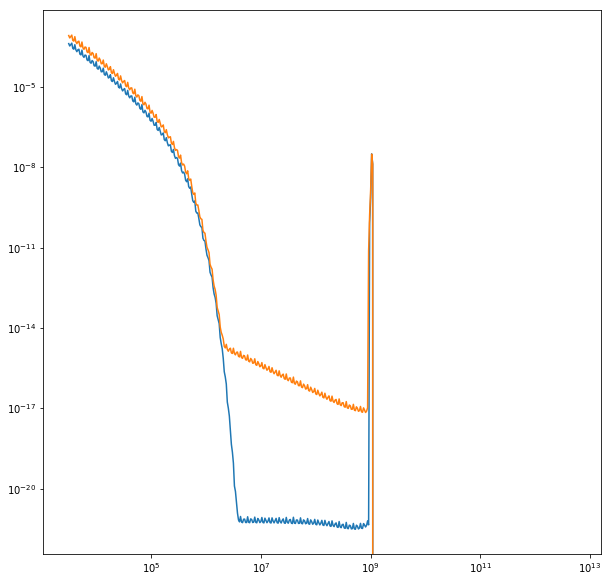

In [26]:
i=1
j=2
print(photon_spectra[i].rs)
print(file_spectra[j].rs)

ax = plt.subplot(1,1,1)
# plt.plot(photon_spectra.eng, photon_spectra[i].dNdE)
# plt.plot(photon_spectra.eng, photon_spectra[i+5].dNdE)
# plt.plot(file_spectra.eng, file_spectra[j-2].dNdE)
plt.plot(file_spectra.eng, file_spectra[j-1].dNdE)
plt.plot(file_spectra.eng, file_spectra[j].dNdE)
ax.set_xscale('log')
ax.set_yscale('log')
# b = file_spectra.plot(2)
# axb = b.add_subplot(1,1,1)
# axb.set_xscale('log')
# axb.set_yscale('log')


/Users/hongwan/GitHub/darkhistory/spectrum.py:339: RuntimeWarning: divide by zero encountered in true_divide
  invSpec = Spectrum(self.eng, 1/self.dNdE, self.rs)
/Users/hongwan/GitHub/darkhistory/spectrum.py:254: RuntimeWarning: invalid value encountered in multiply
  return Spectrum(self.eng, self.dNdE*other.dNdE, self.rs)


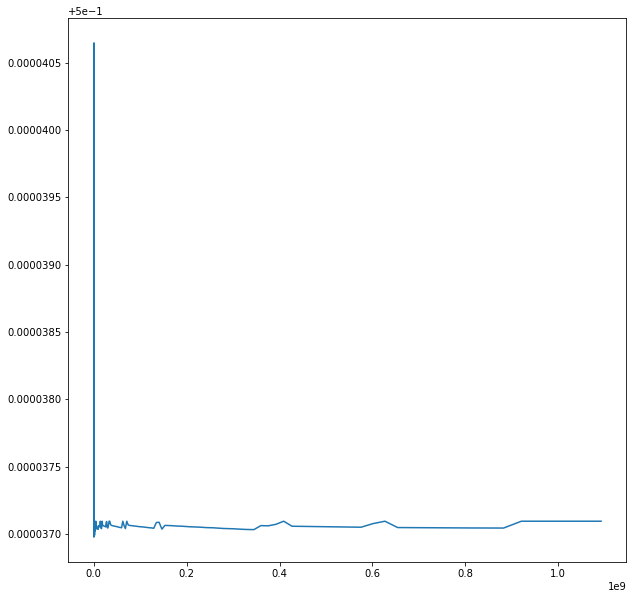

In [80]:
plt.plot(photon_spectra.eng, (photon_spectra[i]/file_spectra[j]).dNdE)

In [40]:
np.set_printoptions(threshold=np.nan)
print(np.stack([photon_spectra[0].dNdE, photon_spectra[1].dNdE,
                file_spectra[1].dNdE, file_spectra[2].dNdE],axis=-1))

[[  0.00000000e+00   8.28428648e-04   4.14624577e-04   8.28367305e-04]
 [  0.00000000e+00   6.73898270e-04   3.37271446e-04   6.73848374e-04]
 [  0.00000000e+00   7.65523336e-04   3.83112887e-04   7.65466661e-04]
 [  0.00000000e+00   8.60169896e-04   4.30464281e-04   8.60106227e-04]
 [  0.00000000e+00   5.46738025e-04   2.73604140e-04   5.46697564e-04]
 [  0.00000000e+00   5.11566363e-04   2.56000505e-04   5.11528502e-04]
 [  0.00000000e+00   7.53119198e-04   3.76864813e-04   7.53063403e-04]
 [  0.00000000e+00   4.88566719e-04   2.44478683e-04   4.88530584e-04]
 [  0.00000000e+00   4.14365678e-04   2.07346686e-04   4.14335014e-04]
 [  0.00000000e+00   4.88435097e-04   2.44407702e-04   4.88398922e-04]
 [  0.00000000e+00   5.10581041e-04   2.55484913e-04   5.10543233e-04]
 [  0.00000000e+00   3.35127245e-04   1.67691479e-04   3.35102433e-04]
 [  0.00000000e+00   3.13432489e-04   1.56835737e-04   3.13409283e-04]
 [  0.00000000e+00   4.74345872e-04   2.37349108e-04   4.74310722e-04]
 [  0.